In this notebook, we will augment the initial data of the ARC AGT-2 Dataset to produce more synthetic data.

We will perform the following processings directly on the task files:

- Rotations
- Mirroring (Horizontal & Vertical)
- Example shuffling (TODO - Consider constraints)
- Color shuffling (full shuffle, including black) (TODO)
- Padding (TODO)

Let's define necessary imports and visualization functions.

In [74]:
import json
import os
import shutil
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import Counter, defaultdict
from tqdm import tqdm
import re
import hashlib # Using json.dumps for simplicity

%matplotlib inline 

ARC_COLORMAP = colors.ListedColormap(
    ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']
)
ARC_NORM = colors.Normalize(vmin=0, vmax=9)

data_dir = "../ARC-AGI/data/training"
output_dir = "modded_tasks"

# --- Grid Display Helper ---
def show_grid(grid, title=None, ax=None):
    # Simplified figsize
    figsize = (max(1, len(grid[0]) * 0.4 if grid else 1), max(1, len(grid) * 0.4))
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    # Assume grid is valid list of lists of int
    ax.imshow(np.array(grid, dtype=int), cmap=ARC_COLORMAP, norm=ARC_NORM)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    if title:
        ax.set_title(title, fontsize=8)

# --- Visualize Task from File Path ---
def visualize_task_from_path(task_path):
    with open(task_path, 'r') as f:
        task_data = json.load(f)
    task_id = Path(task_path).stem
    
    train_examples = task_data.get('train', [])
    test_examples = task_data.get('test', [])
    num_train = len(train_examples)
    num_test = len(test_examples)
    total_cols = num_train + num_test
    if total_cols == 0: return
    
    fig, axs = plt.subplots(2, total_cols, figsize=(min(total_cols * 1.5, 20), 3), squeeze=False)
    plt.suptitle(f"Task: {task_id}", fontsize=10)
    
    for i, ex in enumerate(train_examples):
        show_grid(ex.get('input', []), f"Tr {i+1} In", ax=axs[0, i])
        show_grid(ex.get('output', []), f"Tr {i+1} Out", ax=axs[1, i])
            
    for i, ex in enumerate(test_examples):
        col = num_train + i
        show_grid(ex.get('input', []), f"Te {i+1} In", ax=axs[0, col])
        out_title = f"Te {i+1} Out"
        if 'output' in ex: 
            show_grid(ex['output'], out_title, ax=axs[1, col])
        else: 
            axs[1, col].set_title(f"{out_title}: ?")
            axs[1, col].axis('off')
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close(fig) # Close the figure after showing

# --- Visualize All Variants of a Task ID ---
def visualize_task_variants(task_id, tasks_dir):
    print(f"\n--- Visualizing variants for Task ID: {task_id} ---")
    pattern = re.compile(rf"^{re.escape(task_id)}(?:_[a-zA-Z0-9]+)*\.json$")
    file_list = sorted(os.listdir(tasks_dir))
    for filename in file_list:
        if pattern.match(filename):
            visualize_task_from_path(os.path.join(tasks_dir, filename))

# --- File Counter ---
def count_json_files(folder):
    return len([f for f in os.listdir(folder) if f.lower().endswith('.json') and os.path.isfile(os.path.join(folder, f))])

# --- Duplicate Checker (Simplified) ---
def check_duplicates(tasks_dir):
    print(f"\n--- Checking for duplicate task content in '{tasks_dir}' ---")
    content_map = defaultdict(list)
    json_files = [f for f in os.listdir(tasks_dir) if f.lower().endswith('.json') and os.path.isfile(os.path.join(tasks_dir, f))]
    
    for filename in tqdm(json_files, desc="Checking duplicates"):
        filepath = os.path.join(tasks_dir, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
        canonical_repr = json.dumps(data, sort_keys=True)
        content_map[canonical_repr].append(filename)
        
    duplicate_sets = {k: v for k, v in content_map.items() if len(v) > 1}
    
    if duplicate_sets:
        print(f"Found {len(duplicate_sets)} sets of duplicate task content.")
    else:
        print("No duplicate task content found.")
    return duplicate_sets

print("Setup complete.")

Setup complete.


1. Copy original tasks to the working directory `modded_tasks`.

In [75]:
os.makedirs(output_dir, exist_ok=True)
original_task_paths = sorted(Path(data_dir).glob("*.json"))

print(f"Copying {len(original_task_paths)} original tasks from '{data_dir}' to '{output_dir}'...")
for src_path in tqdm(original_task_paths, desc="Copying originals"):
    dest_path = Path(output_dir) / src_path.name
    # Simple copy, overwrites if exists
    shutil.copy2(src_path, dest_path)
        
print(f"Copy complete. Files in '{output_dir}': {count_json_files(output_dir)}")

Copying 1000 original tasks from '../ARC-AGI/data/training' to 'modded_tasks'...


Copying originals: 100%|██████████| 1000/1000 [00:01<00:00, 523.08it/s]


Copy complete. Files in 'modded_tasks': 1000


Let's check if we can view a task from the new directory.

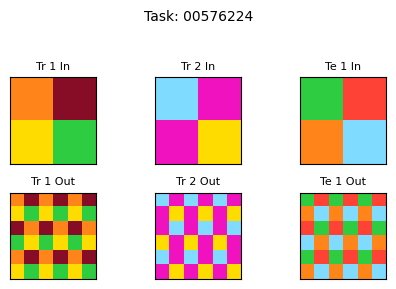

In [76]:
first_task_path = os.path.join(output_dir, original_task_paths[0].name)
visualize_task_from_path(first_task_path)

Okay, now let's further inspect the data... how many train examples, how many test examples, etc., using the copied files.

Analyzing tasks: 100%|██████████| 1000/1000 [00:00<00:00, 1584.26it/s]


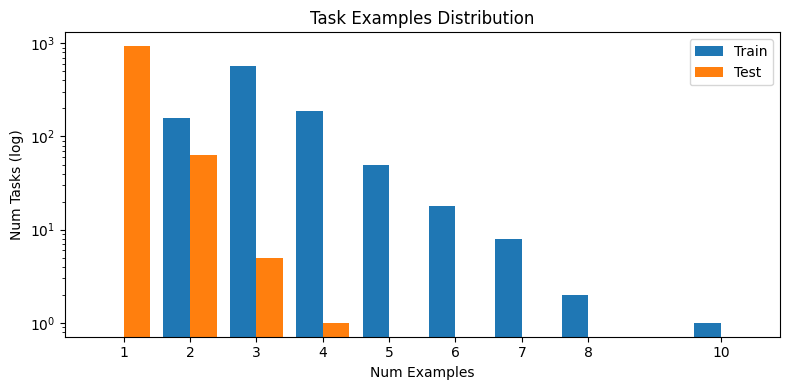

In [77]:
train_counts = []
test_counts = []
output_files = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.json')])

for task_path in tqdm(output_files, desc="Analyzing tasks"):
    with open(task_path, 'r') as f:
        data = json.load(f)
    train_counts.append(len(data.get('train', [])))
    test_counts.append(len(data.get('test', [])))

train_hist = Counter(train_counts)
test_hist = Counter(test_counts)
x_vals = sorted(set(train_hist.keys()).union(test_hist.keys()))
train_vals = [train_hist.get(x, 0) for x in x_vals]
test_vals = [test_hist.get(x, 0) for x in x_vals]

plt.figure(figsize=(8, 4))
plt.bar(np.array(x_vals) - 0.2, train_vals, width=0.4, label='Train')
plt.bar(np.array(x_vals) + 0.2, test_vals, width=0.4, label='Test')
plt.xlabel("Num Examples")
plt.ylabel("Num Tasks (log)")
plt.title("Task Examples Distribution")
plt.xticks(x_vals)
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

There are two outliers.. let's look at them manually, what's going on there?

Checking for outliers (Train > 9 or Test > 3)
Train outlier: 794b24be.json


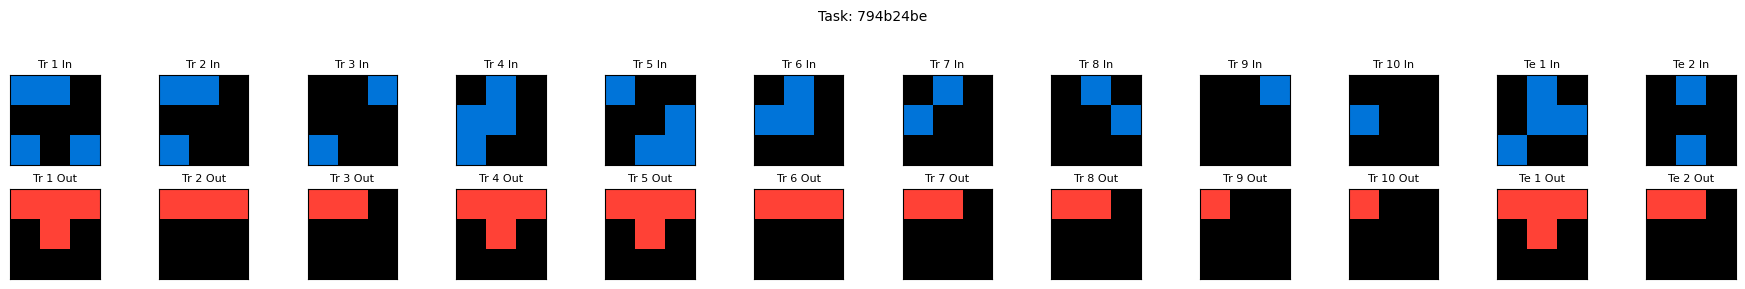

Test outlier: 8dab14c2.json


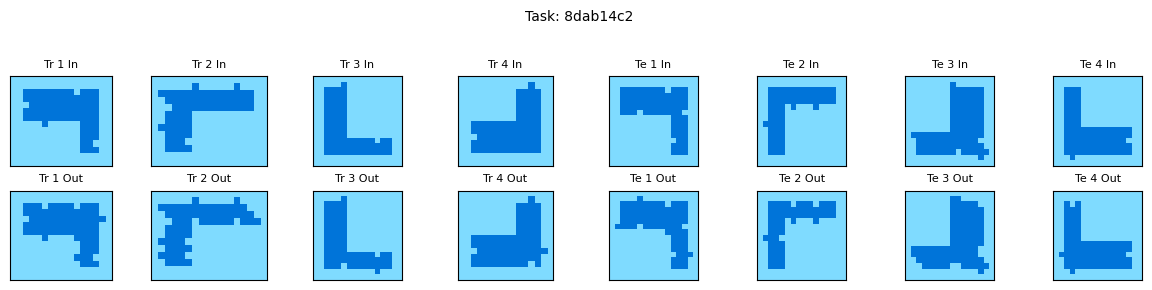

In [78]:
print("Checking for outliers (Train > 9 or Test > 3)")
train_outlier_ids = []
test_outlier_ids = []
for task_path in output_files: # Check files currently in output dir
    with open(task_path, 'r') as f:
        data = json.load(f)
    task_id = Path(task_path).stem
    if len(data.get('train', [])) > 9:
        print(f"Train outlier: {task_id}.json")
        visualize_task_from_path(task_path)
        train_outlier_ids.append(task_id)
    if len(data.get('test', [])) > 3:
        print(f"Test outlier: {task_id}.json")
        visualize_task_from_path(task_path)
        test_outlier_ids.append(task_id)

Okay, so this rules out any permutations that we might have wanted to do in the example shuffling because if we were to have a permutation of `794b24be`, we would have 10! = 3,628,800 different tasks!! We can't do this!

Okay, but we can start doing the transformations and multiplying the ARC tasks like they're rabbits in the summer!

2. Perform Rotation Augmentation.

In [79]:
# Define rotation function just before use
def rotate_grid(grid, angle):
    arr = np.array(grid)
    if angle == 90: return np.rot90(arr, 3).tolist()
    if angle == 180: return np.rot90(arr, 2).tolist()
    if angle == 270: return np.rot90(arr, 1).tolist()
    return grid # Should not happen here

print(f"Applying rotations to tasks in '{output_dir}'...")

# Files that are originals (assuming no '_' in original filenames)
original_filenames = [
    f for f in os.listdir(output_dir) 
    if f.endswith('.json') and '_' not in Path(f).stem
    and os.path.isfile(os.path.join(output_dir, f))
]

for filename in tqdm(original_filenames, desc="Rotating tasks"):
    task_path = os.path.join(output_dir, filename)
    task_id = Path(filename).stem
    
    with open(task_path, 'r') as f:
        task_data = json.load(f)
    
    for angle in [90, 180, 270]:
        rotated_data = {'train': [], 'test': []}
        for key in ['train', 'test']:
            for pair in task_data.get(key, []):
                rotated_pair = {}
                if 'input' in pair: rotated_pair['input'] = rotate_grid(pair.get('input', []), angle)
                if 'output' in pair: rotated_pair['output'] = rotate_grid(pair.get('output', []), angle)
                rotated_data[key].append(rotated_pair) 
                
        rot_filename = f"{task_id}_r{angle}.json"
        rot_filepath = os.path.join(output_dir, rot_filename)
        # Overwrite if exists (or use 'if not os.path.exists(rot_filepath):' to skip)
        with open(rot_filepath, 'w') as f_out:
            json.dump(rotated_data, f_out)

print(f"Rotation complete. Files in '{output_dir}': {count_json_files(output_dir)}")

Applying rotations to tasks in 'modded_tasks'...


Rotating tasks: 100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Rotation complete. Files in 'modded_tasks': 4000


3. Perform Mirroring Augmentation (Horizontal and Vertical).

Apply mirroring to all files currently in the directory (originals and rotated versions).

In [80]:
import json
import os
import shutil
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
from collections import Counter, defaultdict
from tqdm import tqdm
import re
import hashlib # Using json.dumps for simplicity

# Define mirroring function just before use
def mirror_grid(grid, direction):
    arr = np.array(grid)
    if direction == 'h': return np.fliplr(arr).tolist() # Horizontal mirror
    # Keep vertical mirror capability in the function, but don't call it
    # if direction == 'v': return np.flipud(arr).tolist() # Vertical mirror
    return grid

# --- File Counter (assuming defined elsewhere or copy from previous cell) ---
def count_json_files(folder):
    return len([f for f in os.listdir(folder) if f.lower().endswith('.json') and os.path.isfile(os.path.join(folder, f))])

# --- Assume output_dir is defined ---
# output_dir = "modded_tasks"

print(f"Applying HORIZONTAL mirroring to tasks in '{output_dir}'...")

# Get all current JSON files that haven't been horizontally mirrored yet
# (originals and rotated versions)
current_files = sorted([
    f for f in os.listdir(output_dir)
    if f.endswith('.json') and '_mh' not in f # Only process files without _mh suffix
    and os.path.isfile(os.path.join(output_dir, f))
])

for filename in tqdm(current_files, desc="Horizontally Mirroring tasks"):
    task_path = os.path.join(output_dir, filename)
    task_id_base = Path(filename).stem # e.g., "taskid" or "taskid_r90"

    # We are only processing files that don't have '_mh', so no need to skip here

    with open(task_path, 'r') as f:
        task_data = json.load(f)

    # --- Only apply horizontal mirroring ---
    direction = 'h'
    suffix = 'mh'

    mirrored_data = {'train': [], 'test': []}
    for key in ['train', 'test']:
        for pair in task_data.get(key, []):
            mirrored_pair = {}
            # Use .get with default [] to handle potentially missing input/output gracefully
            if 'input' in pair: mirrored_pair['input'] = mirror_grid(pair.get('input', []), direction)
            if 'output' in pair: mirrored_pair['output'] = mirror_grid(pair.get('output', []), direction)
            mirrored_data[key].append(mirrored_pair)

    mir_filename = f"{task_id_base}_{suffix}.json"
    mir_filepath = os.path.join(output_dir, mir_filename)
    # Overwrite if exists
    with open(mir_filepath, 'w') as f_out:
        json.dump(mirrored_data, f_out)

print(f"Horizontal Mirroring complete. Files in '{output_dir}': {count_json_files(output_dir)}")

Applying HORIZONTAL mirroring to tasks in 'modded_tasks'...


Horizontally Mirroring tasks: 100%|██████████| 4000/4000 [00:27<00:00, 146.47it/s]


Horizontal Mirroring complete. Files in 'modded_tasks': 8000


Visualize variants for one task ID to check rotations and mirroring.


--- Visualizing variants for Task ID: 00576224 ---


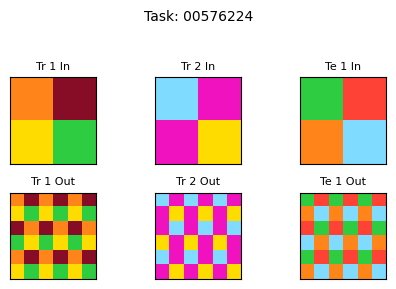

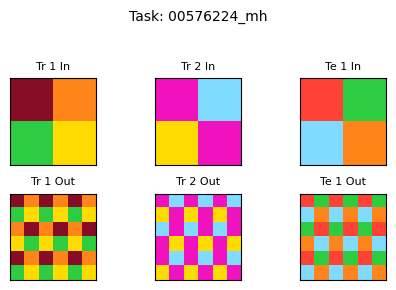

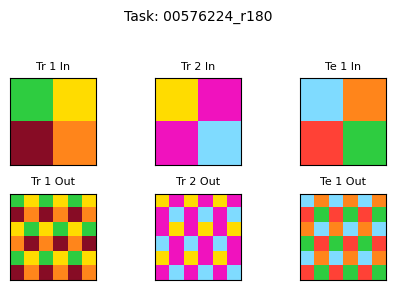

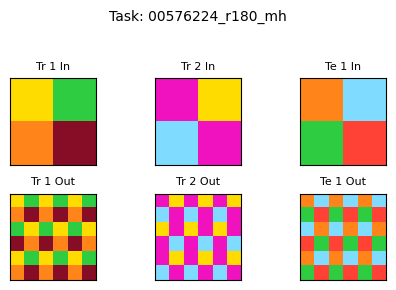

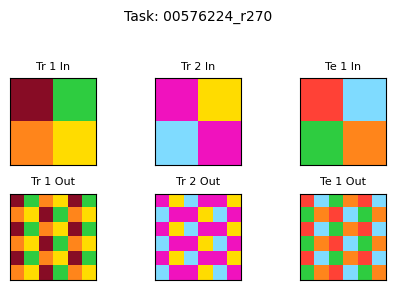

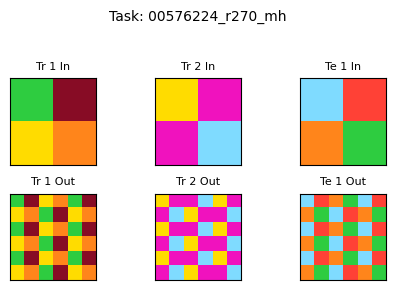

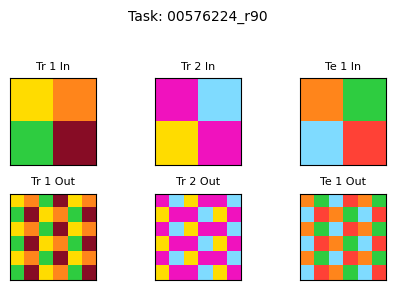

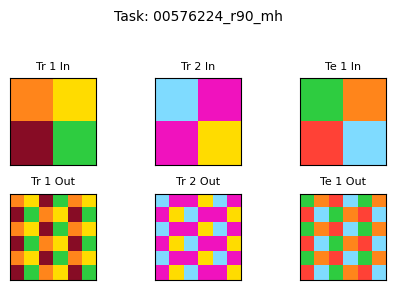


--- Visualizing variants for Task ID: 794b24be ---


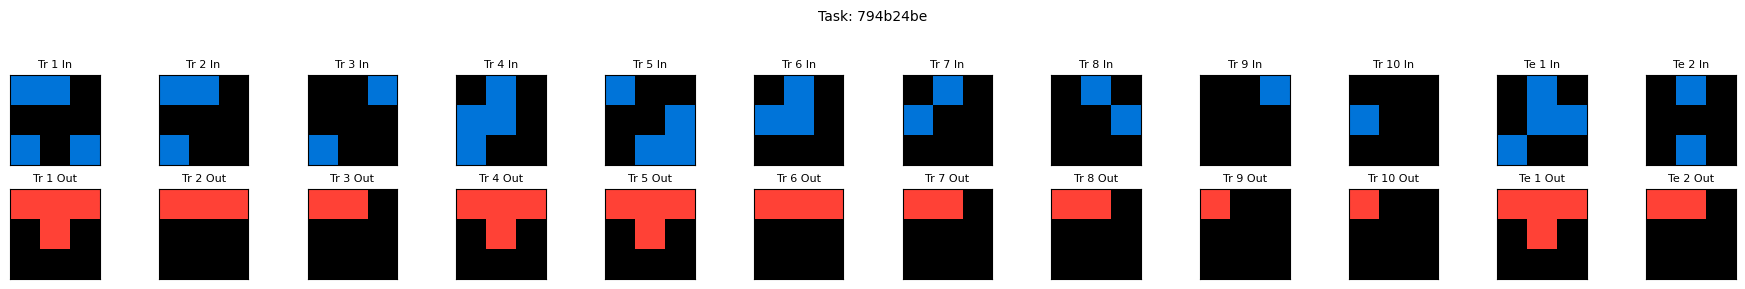

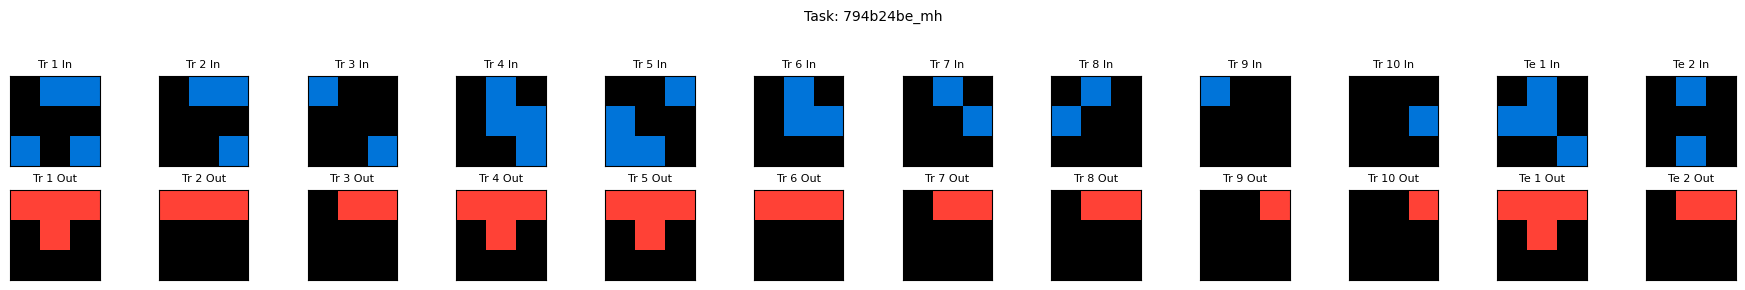

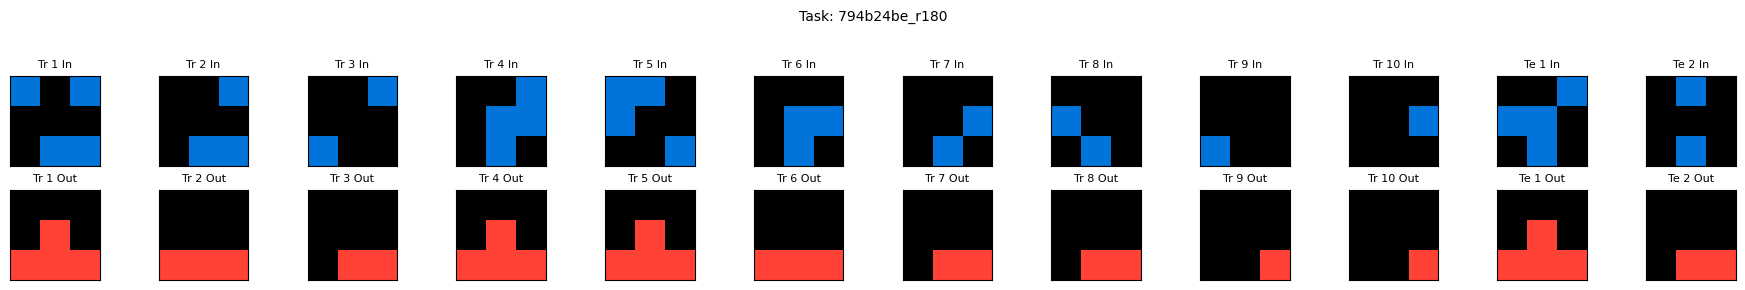

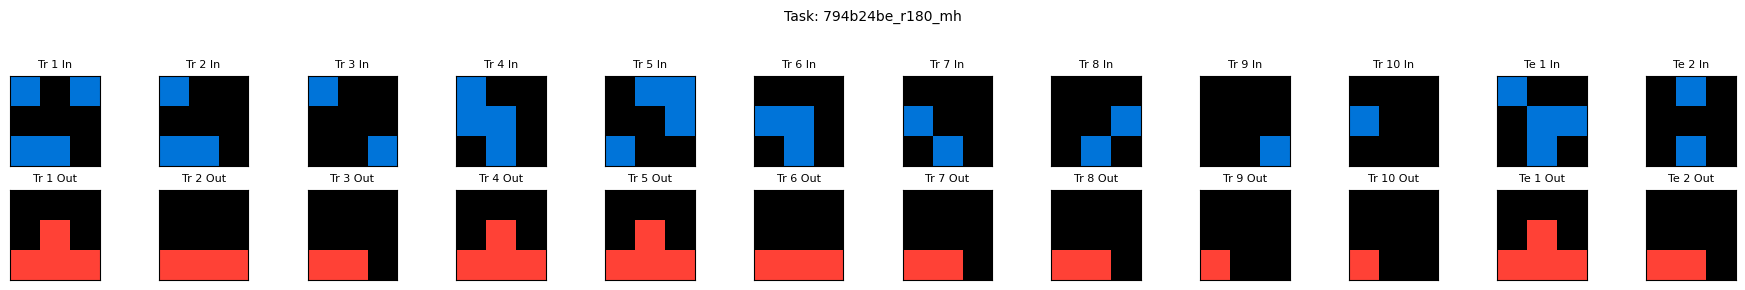

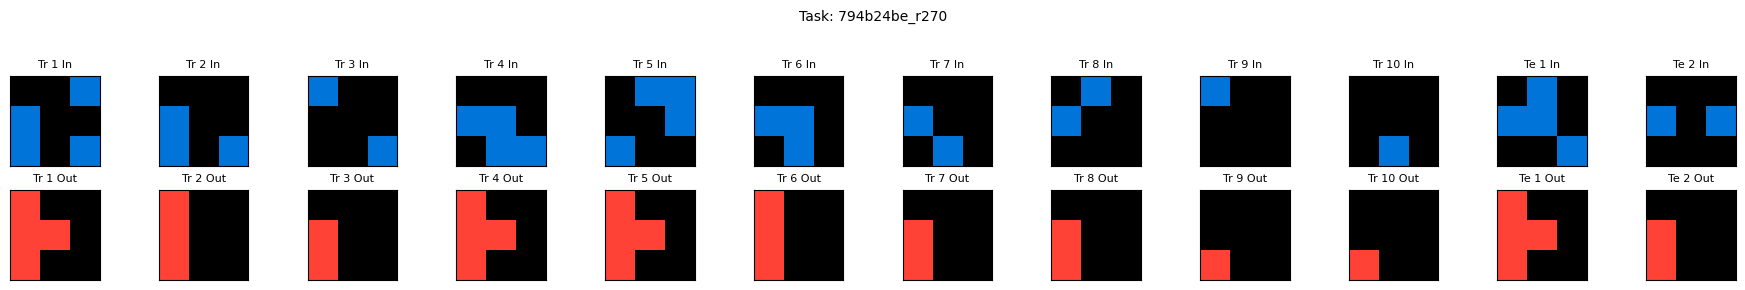

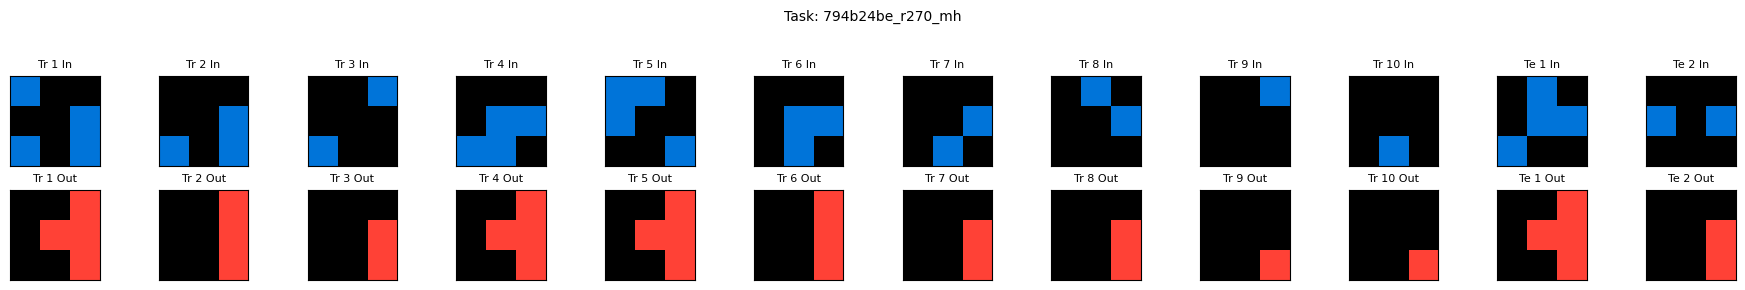

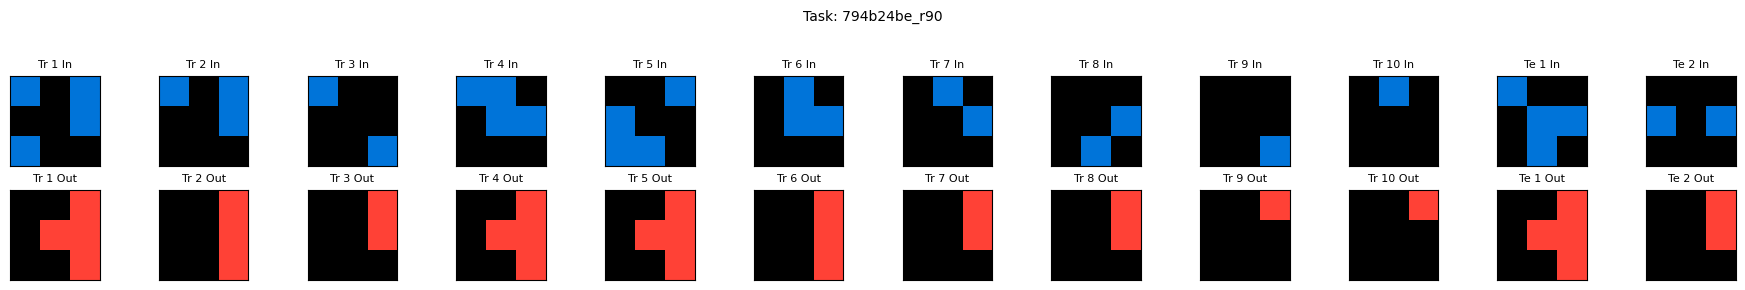

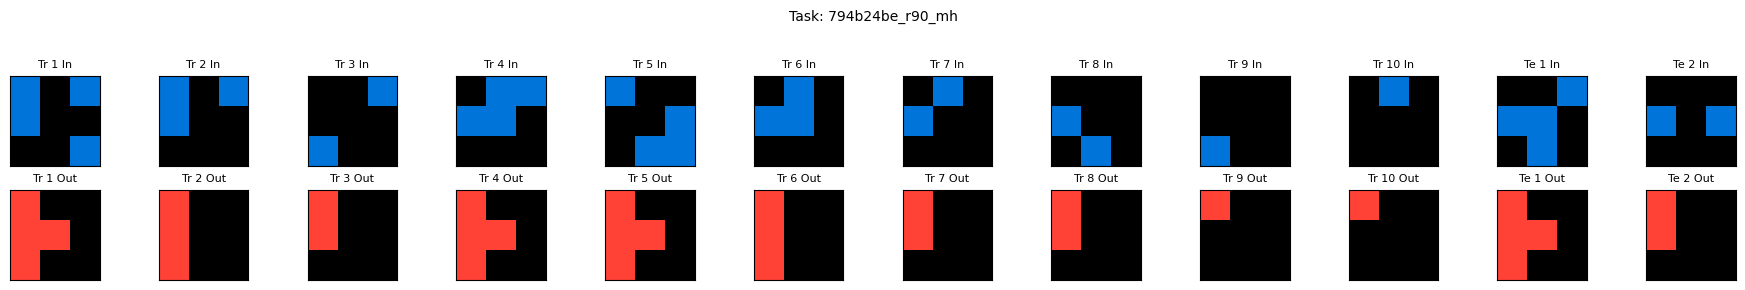

In [81]:
# Get list of original IDs again to pick one
original_ids = sorted([Path(f).stem for f in original_filenames])
if original_ids:
    example_id_to_show = original_ids[0] # Show variants for the first original task
    visualize_task_variants(example_id_to_show, output_dir)
    
    # Also show an outlier if its ID is in the list
    if '794b24be' in original_ids:
        visualize_task_variants('794b24be', output_dir)
else:
    print("Could not find original task IDs to visualize variants.")

Check for duplicate task content after augmentations.

In [82]:
duplicates = check_duplicates(output_dir)


--- Checking for duplicate task content in 'modded_tasks' ---


Checking duplicates: 100%|██████████| 8000/8000 [00:05<00:00, 1452.10it/s]

Found 80 sets of duplicate task content.


Somehow we now have 3984 duplciates . Lets investigate...

In [83]:
# --- Investigate Duplicate Types (Simple) ---
from itertools import combinations
from collections import defaultdict
from pathlib import Path
import os
import re
import json
from tqdm import tqdm

# --- Helper to extract augmentation type from filename stem ---
# Assumes format taskid_suffix1_suffix2...json
def get_augmentation_type(filename_stem):
    parts = filename_stem.split('_')
    if len(parts) == 1:
        return 'original'
    # Sort suffixes (r90, mh, etc.) alphabetically for consistent naming
    return '_'.join(sorted(parts[1:]))

# --- Analyze Duplicate Types ---
def analyze_duplicate_types_simple(duplicate_sets, tasks_dir):
    print(f"\n--- Analyzing types of duplicates found ---")

    duplicate_pair_counts = defaultdict(int)
    task_ids_with_duplicates = set() # Keep track of original task IDs involved

    # Identify original filenames to count total original tasks
    original_filenames = [
        f for f in os.listdir(tasks_dir)
        if f.endswith('.json') and '_' not in Path(f).stem
        and os.path.isfile(os.path.join(tasks_dir, f))
    ]
    total_original_tasks = len(original_filenames)

    print(f"Analyzing {len(duplicate_sets)} sets of duplicate content...")
    for filenames_list in tqdm(duplicate_sets.values(), desc="Analyzing duplicate sets"):
        # Get unique augmentation types present in this duplicate set
        # Also get the base task ID (assuming all duplicates in a set share the same base ID)
        base_task_id = None
        aug_types_in_set = set()
        for fname in filenames_list:
            stem = Path(fname).stem
            if base_task_id is None:
                base_task_id = stem.split('_')[0] # Extract base ID
            aug_types_in_set.add(get_augmentation_type(stem))

        if base_task_id:
             task_ids_with_duplicates.add(base_task_id)

        # Count pairs of *different* augmentation types that are identical within this set
        # Convert set to sorted list for combinations
        sorted_types = sorted(list(aug_types_in_set))
        for type1, type2 in combinations(sorted_types, 2):
            # Ensure consistent ordering (e.g., alphabetical) for pair key
            pair_key = tuple(sorted((type1, type2)))
            duplicate_pair_counts[pair_key] += 1

    print("\nDuplicate Pair Statistics:")
    if not duplicate_pair_counts:
        print("No duplicates found between *different* augmentation types.")
        return

    # Sort pairs by frequency for better readability
    sorted_pairs = sorted(duplicate_pair_counts.items(), key=lambda item: item[1], reverse=True)

    print(f"(Percentages calculated relative to {total_original_tasks} original tasks)")
    for pair, count in sorted_pairs:
        percentage = (count / total_original_tasks) * 100 if total_original_tasks > 0 else 0
        print(f"  - Pair: {pair}, Count: {count} ({percentage:.1f}%)")

    print(f"\nTotal original tasks with *any* augmentation duplication: {len(task_ids_with_duplicates)}")


# --- Run the analysis ---
analyze_duplicate_types_simple(duplicates, output_dir)


--- Analyzing types of duplicates found ---
Analyzing 80 sets of duplicate content...


Analyzing duplicate sets: 100%|██████████| 80/80 [00:00<00:00, 26645.30it/s]


Duplicate Pair Statistics:
(Percentages calculated relative to 1000 original tasks)
  - Pair: ('mh', 'original'), Count: 13 (1.3%)
  - Pair: ('mh_r180', 'r180'), Count: 13 (1.3%)
  - Pair: ('mh_r270', 'r90'), Count: 13 (1.3%)
  - Pair: ('mh_r90', 'r270'), Count: 13 (1.3%)
  - Pair: ('mh_r90', 'original'), Count: 10 (1.0%)
  - Pair: ('mh', 'r90'), Count: 10 (1.0%)
  - Pair: ('mh_r270', 'r180'), Count: 10 (1.0%)
  - Pair: ('mh_r180', 'r270'), Count: 10 (1.0%)
  - Pair: ('mh_r180', 'original'), Count: 8 (0.8%)
  - Pair: ('mh', 'r180'), Count: 8 (0.8%)
  - Pair: ('mh_r270', 'r270'), Count: 8 (0.8%)
  - Pair: ('mh_r90', 'r90'), Count: 8 (0.8%)
  - Pair: ('mh', 'mh_r180'), Count: 7 (0.7%)
  - Pair: ('mh_r270', 'mh_r90'), Count: 7 (0.7%)
  - Pair: ('original', 'r180'), Count: 7 (0.7%)
  - Pair: ('r270', 'r90'), Count: 7 (0.7%)
  - Pair: ('mh_r270', 'original'), Count: 6 (0.6%)
  - Pair: ('mh', 'r270'), Count: 6 (0.6%)
  - Pair: ('mh_r90', 'r180'), Count: 6 (0.6%)
  - Pair: ('mh_r180', 'r90')

okay, we clearly see that mh and mv_r180 are resulting with a 100% certainty in the same trasnfrom so we can remove those trasnformations.

Now lets add paddings arund them

In [84]:
import json
import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
import random
import re

# --- Assume output_dir and count_json_files are defined ---
# output_dir = "modded_tasks"
# def count_json_files(folder): ...

# --- Padding Configuration ---
input_padding_probability = 0.5  # 50% chance to pad inputs
output_padding_probability = 0.5 # 50% chance to pad outputs

# --- Padding Function (defined locally) ---
def pad_grid(grid, width, color):
    if not grid or not grid[0]:
        return [] # Return empty for empty input grid
    arr = np.array(grid, dtype=int)
    padded_arr = np.pad(arr, pad_width=width, mode='constant', constant_values=color)
    return padded_arr.tolist()

print(f"Applying conditional padding to tasks in '{output_dir}'...")

# Get all current JSON files to potentially apply padding to
current_files = sorted([
    f for f in os.listdir(output_dir)
    if f.endswith('.json') and os.path.isfile(os.path.join(output_dir, f))
])

padded_files_created = 0
for filename in tqdm(current_files, desc="Padding tasks"):
    task_path = os.path.join(output_dir, filename)
    task_id_base = Path(filename).stem # e.g., "taskid" or "taskid_r90_mh"

    # Skip if this is already a padded version
    if re.search(r'_p\d+c\d+$', task_id_base):
        continue

    # --- Decide whether to pad input and/or output for this task file ---
    pad_input_decision = random.random() < input_padding_probability
    pad_output_decision = random.random() < output_padding_probability

    # --- Skip if no padding is to be applied ---
    if not pad_input_decision and not pad_output_decision:
        continue

    # --- Choose random padding parameters (only if padding is needed) ---
    pad_width = random.randint(1, 2)
    pad_color = random.randint(0, 9)

    # --- Load and process the task ---
    with open(task_path, 'r') as f:
        task_data = json.load(f)

    padded_data = {'train': [], 'test': []}
    for key in ['train', 'test']:
        for pair in task_data.get(key, []):
            padded_pair = {}
            # Apply padding based on decisions
            if 'input' in pair:
                grid_to_pad = pair.get('input', [])
                padded_pair['input'] = pad_grid(grid_to_pad, pad_width, pad_color) if pad_input_decision and grid_to_pad else grid_to_pad
            if 'output' in pair:
                 grid_to_pad = pair.get('output', [])
                 padded_pair['output'] = pad_grid(grid_to_pad, pad_width, pad_color) if pad_output_decision and grid_to_pad else grid_to_pad
            padded_data[key].append(padded_pair)

    # --- Save the new padded file ---
    # Filename indicates padding parameters used, but not specifically which (input/output) was padded
    pad_filename = f"{task_id_base}_p{pad_width}c{pad_color}.json"
    pad_filepath = os.path.join(output_dir, pad_filename)

    with open(pad_filepath, 'w') as f_out:
        json.dump(padded_data, f_out)
    padded_files_created +=1


print(f"\nConditional Padding complete. Created {padded_files_created} new padded files.")
print(f"Total files in '{output_dir}': {count_json_files(output_dir)}")

Applying conditional padding to tasks in 'modded_tasks'...


Padding tasks: 100%|██████████| 8000/8000 [00:45<00:00, 174.01it/s]



Conditional Padding complete. Created 5998 new padded files.
Total files in 'modded_tasks': 13998



--- Visualizing variants for Task ID: 1f85a75f ---


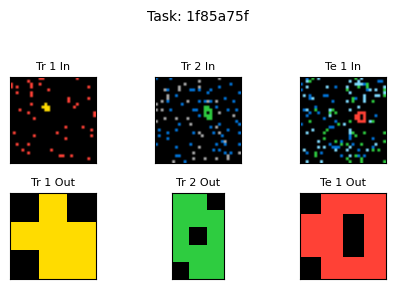

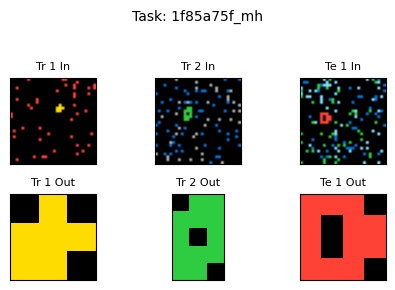

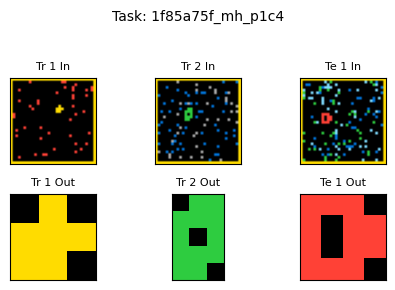

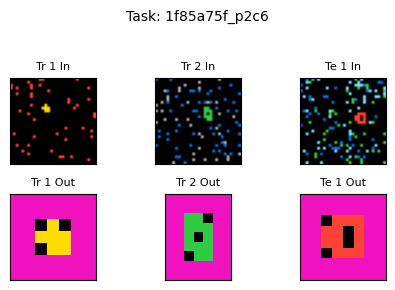

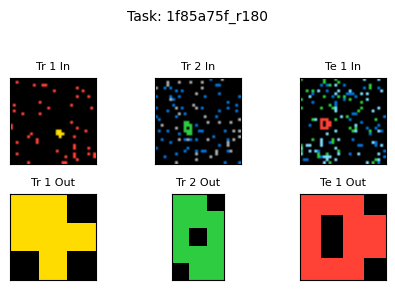

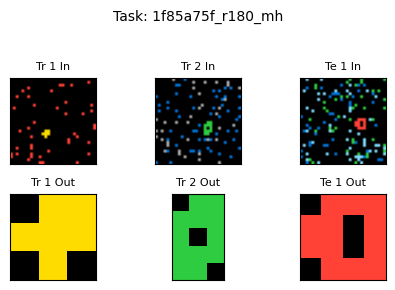

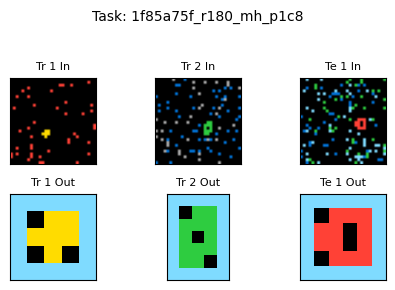

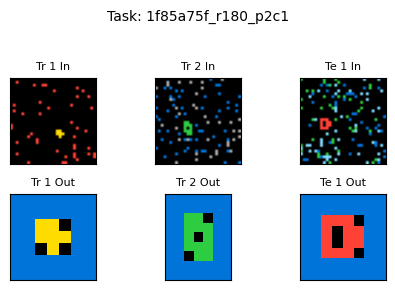

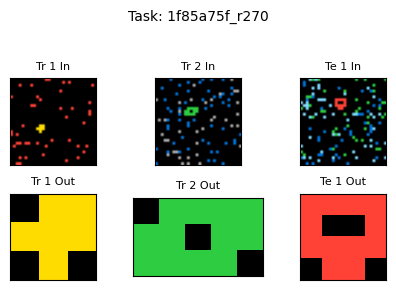

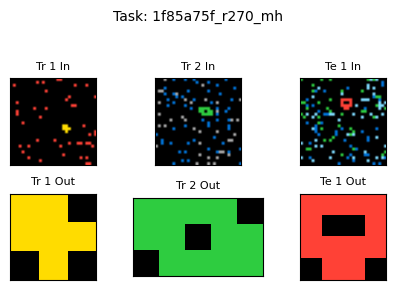

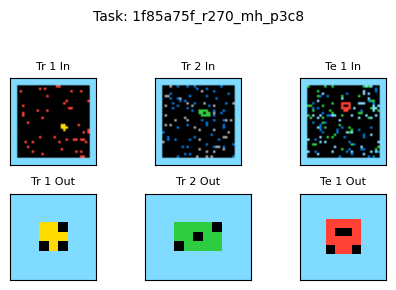

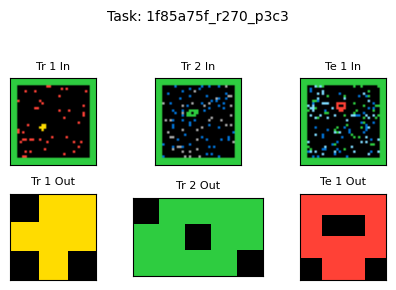

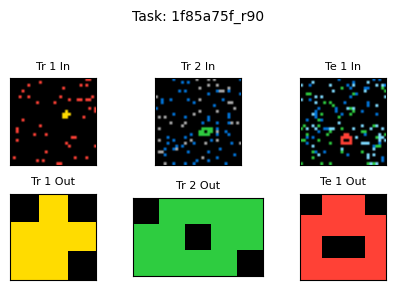

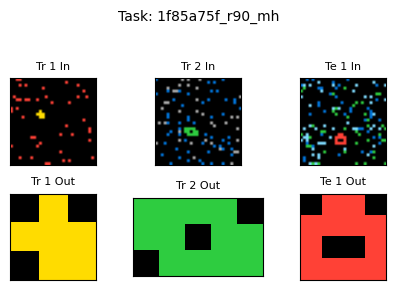

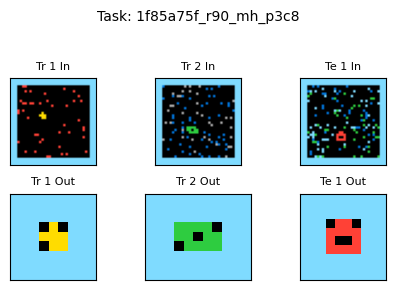

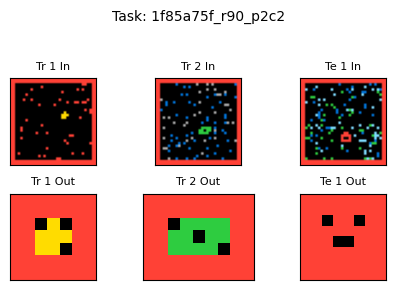

In [73]:
visualize_task_variants("1f85a75f", "modded_tasks")